# Tutorial 1: LIF Neuron Basics

In this tutorial, you'll learn how to:

- Create and configure LIF neurons
- Simulate neuron dynamics
- Analyze neuron behavior
- Understand different reset modes
- Work with physical units

In [1]:
import brainpy
import brainstate
import brainunit as u
import braintools
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np

print(f"BrainPy version: {brainpy.__version__}")

BrainPy version: 2.7.2


## Part 1: Understanding the LIF Model

The Leaky Integrate-and-Fire (LIF) neuron is described by:

$$\tau \frac{dV}{dt} = -(V - V_{rest}) + R \cdot I(t)$$

Where:
- $V$ is the membrane potential
- $\tau$ is the membrane time constant
- $V_{rest}$ is the resting potential
- $R$ is the input resistance
- $I(t)$ is the input current

When $V \geq V_{th}$ (threshold), the neuron spikes and resets.

## Part 2: Creating Your First LIF Neuron

In [3]:
# Set simulation time step
brainstate.environ.set(dt=0.1 * u.ms)

# Create a single LIF neuron
neuron = brainpy.state.LIF(
    in_size=1,
    V_rest=-65. * u.mV,      # Resting potential
    V_th=-50. * u.mV,        # Spike threshold
    V_reset=-65. * u.mV,     # Reset potential
    tau=10. * u.ms,          # Membrane time constant
    R=1. * u.ohm,            # Input resistance
    spk_reset='hard'         # Reset mode
)

# Initialize neuron state
brainstate.nn.init_all_states(neuron)

print("Neuron created successfully!")
print(f"Initial membrane potential: {neuron.V.value}")

Neuron created successfully!
Initial membrane potential: ArrayImpl([0.], dtype=float32) * mvolt


## Part 3: Response to Constant Input

Let's see how the neuron responds to a constant input current.

In [4]:
# Reset neuron
brainstate.nn.init_all_states(neuron)

# Simulation parameters
duration = 200. * u.ms
dt = brainstate.environ.get_dt()
times = u.math.arange(0. * u.ms, duration, dt)

# Constant input current
I_input = 20.0 * u.mA

# Run simulation
voltages = []
spikes = []

for t in times:
    neuron(I_input)
    voltages.append(neuron.V.value)
    spikes.append(neuron.get_spike()[0])  # Single neuron

voltages = u.math.asarray(voltages)
spikes = u.math.asarray(spikes)

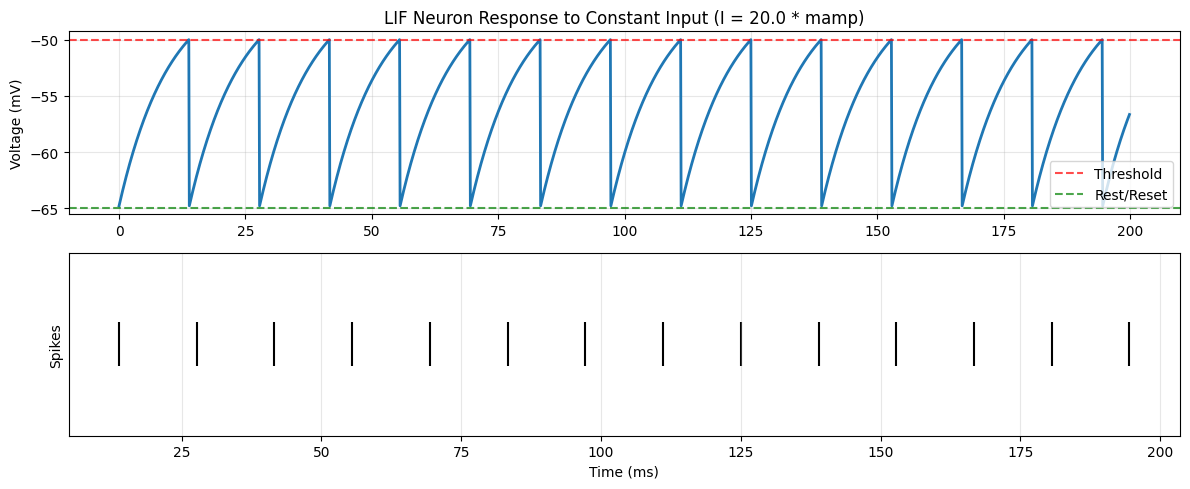

Number of spikes: 14
Firing rate: 70.00 Hz
Mean ISI: 13.90 ms
ISI CV: 0.000


In [6]:
# Plot results
times_plot = times.to_decimal(u.ms)
voltages_plot = voltages.to_decimal(u.mV)

plt.figure(figsize=(12, 5))

# Membrane potential
plt.subplot(2, 1, 1)
plt.plot(times_plot, voltages_plot, linewidth=2)
plt.axhline(y=-50, color='r', linestyle='--', alpha=0.7, label='Threshold')
plt.axhline(y=-65, color='g', linestyle='--', alpha=0.7, label='Rest/Reset')
plt.ylabel('Voltage (mV)')
plt.title(f'LIF Neuron Response to Constant Input (I = {I_input})')
plt.legend()
plt.grid(True, alpha=0.3)

# Spike raster
plt.subplot(2, 1, 2)
spike_times = times_plot[spikes > 0]
plt.scatter(spike_times, [0]*len(spike_times), marker='|', s=1000, c='black')
plt.ylabel('Spikes')
plt.xlabel('Time (ms)')
plt.ylim([-0.5, 0.5])
plt.yticks([])
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
n_spikes = int(u.math.sum(spikes > 0))
firing_rate = n_spikes / (duration.to_decimal(u.second))
print(f"Number of spikes: {n_spikes}")
print(f"Firing rate: {firing_rate:.2f} Hz")

if n_spikes > 1:
    isis = jnp.diff(times_plot[spikes > 0])  # Inter-spike intervals
    print(f"Mean ISI: {jnp.mean(isis):.2f} ms")
    print(f"ISI CV: {jnp.std(isis)/jnp.mean(isis):.3f}")  # Coefficient of variation

## Part 4: F-I Curve (Frequency-Current Relationship)

Let's explore how firing rate changes with input current.

In [7]:
# Range of input currents
currents = u.math.linspace(0 * u.mA, 20 * u.mA, 10)
firing_rates = []

duration = 500. * u.ms
times = u.math.arange(0. * u.ms, duration, dt)

# for I in currents:
for i, I in enumerate(currents):
    # Reset neuron
    brainstate.nn.init_all_states(neuron)
    
    # Simulate
    spike_count = 0
    for t in times:
        neuron(I)
        if neuron.get_spike()[0] > 0:
            spike_count += 1
    
    # Calculate firing rate
    rate = spike_count / (duration.to_decimal(u.second))
    firing_rates.append(rate)
    print(f"Completed {i+1}/{len(currents)}: I = {I}, rate = {rate} Hz")

firing_rates = jnp.array(firing_rates)

Completed 1/10: I = 0.0 * mamp, rate = 0.0 Hz
Completed 2/10: I = 2.222222328186035 * mamp, rate = 0.0 Hz
Completed 3/10: I = 4.44444465637207 * mamp, rate = 0.0 Hz
Completed 4/10: I = 6.6666669845581055 * mamp, rate = 0.0 Hz
Completed 5/10: I = 8.88888931274414 * mamp, rate = 0.0 Hz
Completed 6/10: I = 11.111111640930176 * mamp, rate = 0.0 Hz
Completed 7/10: I = 13.333333969116211 * mamp, rate = 0.0 Hz
Completed 8/10: I = 15.55555534362793 * mamp, rate = 28.0 Hz
Completed 9/10: I = 17.77777862548828 * mamp, rate = 52.0 Hz
Completed 10/10: I = 20.0 * mamp, rate = 70.0 Hz


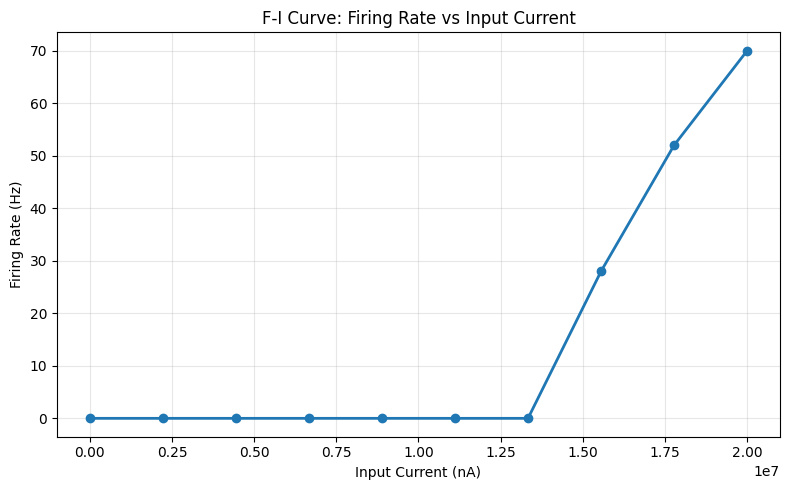

Rheobase (minimum spiking current): 15.55555534362793 * mamp


In [9]:
# Plot F-I curve
plt.figure(figsize=(8, 5))
plt.plot(currents.to_decimal(u.nA), firing_rates, 'o-', linewidth=2, markersize=6)
plt.xlabel('Input Current (nA)')
plt.ylabel('Firing Rate (Hz)')
plt.title('F-I Curve: Firing Rate vs Input Current')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find rheobase (minimum current for spiking)
spiking_currents = currents[firing_rates > 0]
if len(spiking_currents) > 0:
    rheobase = spiking_currents[0]
    print(f"Rheobase (minimum spiking current): {rheobase}")

## Part 5: Soft vs Hard Reset

LIF neurons can use different reset mechanisms:

- **Hard reset**: $V \leftarrow V_{reset}$ (discards extra charge)
- **Soft reset**: $V \leftarrow V - V_{th}$ (preserves extra charge)

Let's compare their behavior.

In [10]:
# Create two neurons with different reset modes
neuron_hard = brainpy.state.LIF(
    1,
    V_rest=-65. * u.mV,
    V_th=-50. * u.mV,
    V_reset=-65. * u.mV,
    tau=10. * u.ms,
    spk_reset='hard'
)

neuron_soft = brainpy.state.LIF(
    1,
    V_rest=-65. * u.mV,
    V_th=-50. * u.mV,
    V_reset=-65. * u.mV,  # Not used in soft reset
    tau=10. * u.ms,
    spk_reset='soft'
)

# Initialize
brainstate.nn.init_all_states(neuron_hard)
brainstate.nn.init_all_states(neuron_soft)

# Simulate both with same input
duration = 200. * u.ms
times = u.math.arange(0. * u.ms, duration, dt)
I_input = 20.0 * u.mA  # Strong input

voltages_hard = []
voltages_soft = []
spikes_hard = []
spikes_soft = []

for t in times:
    neuron_hard(I_input)
    neuron_soft(I_input)
    
    voltages_hard.append(neuron_hard.V.value)
    voltages_soft.append(neuron_soft.V.value)
    spikes_hard.append(neuron_hard.get_spike()[0])
    spikes_soft.append(neuron_soft.get_spike()[0])

voltages_hard = u.math.asarray(voltages_hard)
voltages_soft = u.math.asarray(voltages_soft)
spikes_hard = u.math.asarray(spikes_hard)
spikes_soft = u.math.asarray(spikes_soft)

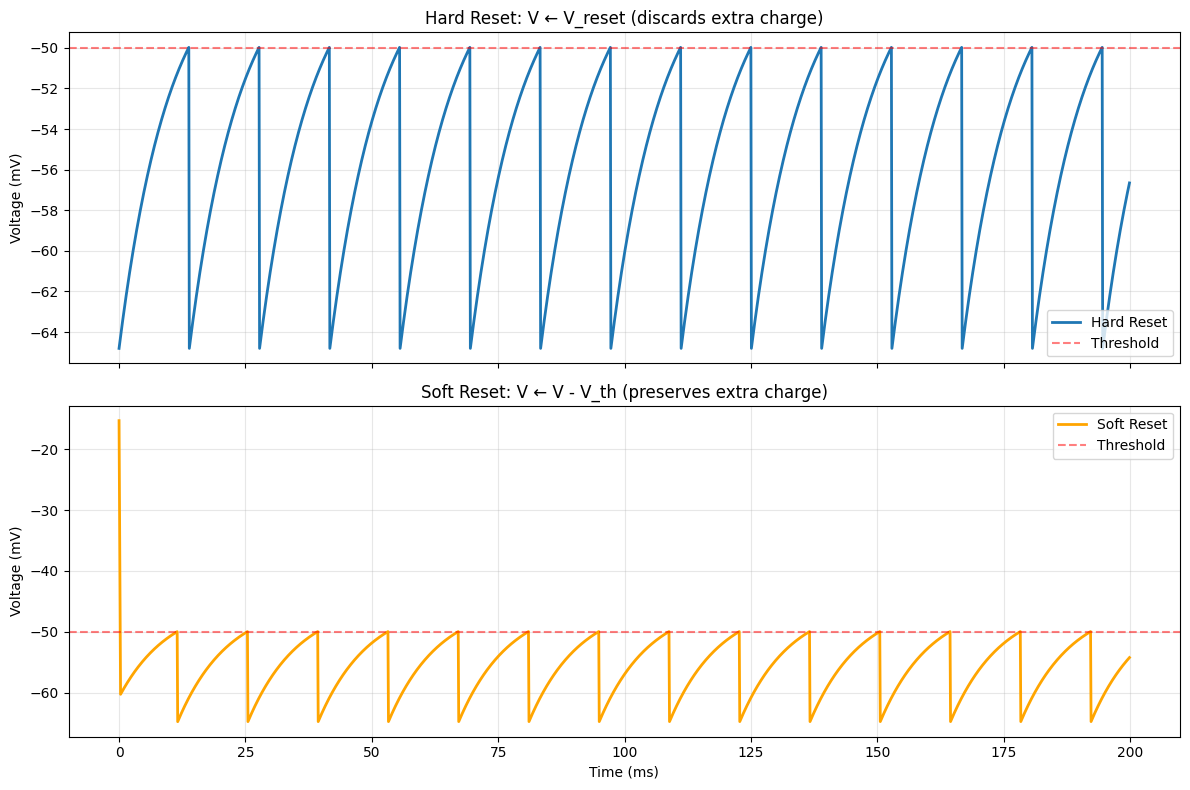

Hard reset: 14 spikes, 70.00 Hz
Soft reset: 17 spikes, 85.00 Hz

Soft reset fires 21.4% more frequently


In [11]:
# Plot comparison
times_plot = times.to_decimal(u.ms)

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Hard reset
axes[0].plot(times_plot, voltages_hard.to_decimal(u.mV), linewidth=2, label='Hard Reset')
axes[0].axhline(y=-50, color='r', linestyle='--', alpha=0.5, label='Threshold')
axes[0].set_ylabel('Voltage (mV)')
axes[0].set_title('Hard Reset: V ← V_reset (discards extra charge)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Soft reset
axes[1].plot(times_plot, voltages_soft.to_decimal(u.mV), linewidth=2, label='Soft Reset', color='orange')
axes[1].axhline(y=-50, color='r', linestyle='--', alpha=0.5, label='Threshold')
axes[1].set_ylabel('Voltage (mV)')
axes[1].set_xlabel('Time (ms)')
axes[1].set_title('Soft Reset: V ← V - V_th (preserves extra charge)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare firing rates
n_spikes_hard = int(u.math.sum(spikes_hard > 0))
n_spikes_soft = int(u.math.sum(spikes_soft > 0))
rate_hard = n_spikes_hard / (duration.to_decimal(u.second))
rate_soft = n_spikes_soft / (duration.to_decimal(u.second))

print(f"Hard reset: {n_spikes_hard} spikes, {rate_hard:.2f} Hz")
print(f"Soft reset: {n_spikes_soft} spikes, {rate_soft:.2f} Hz")
print(f"\nSoft reset fires {(rate_soft/rate_hard - 1)*100:.1f}% more frequently")

## Part 6: Population of LIF Neurons

Now let's create a population of neurons with heterogeneous properties.

In [13]:
# Create population with varied initial conditions
pop_size = 50
neuron_pop = brainpy.state.LIF(
    pop_size,
    V_rest=-65. * u.mV,
    V_th=-50. * u.mV,
    V_reset=-65. * u.mV,
    tau=10. * u.ms,
    V_initializer=braintools.init.Normal(-65., 5., unit=u.mV),  # Random initial V
    spk_reset='hard'
)

# Initialize
brainstate.nn.init_all_states(neuron_pop)

# Simulate with step current
duration = 300. * u.ms
times = u.math.arange(0. * u.ms, duration, dt)

spike_history = []
for t in times:
    # Step current: 0 → 2.5 nA at t=50ms
    I = 20. * u.mA if t > 50. *u.ms else 0 * u.mA
    neuron_pop(I)
    spike_history.append(neuron_pop.get_spike())

spike_history = u.math.asarray(spike_history)

d:\soft\Anaconda3\envs\Ecosystem-py\Lib\site-packages\braintools\surrogate.py:72: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  z = jnp.asarray(x >= 0, dtype=x.dtype)


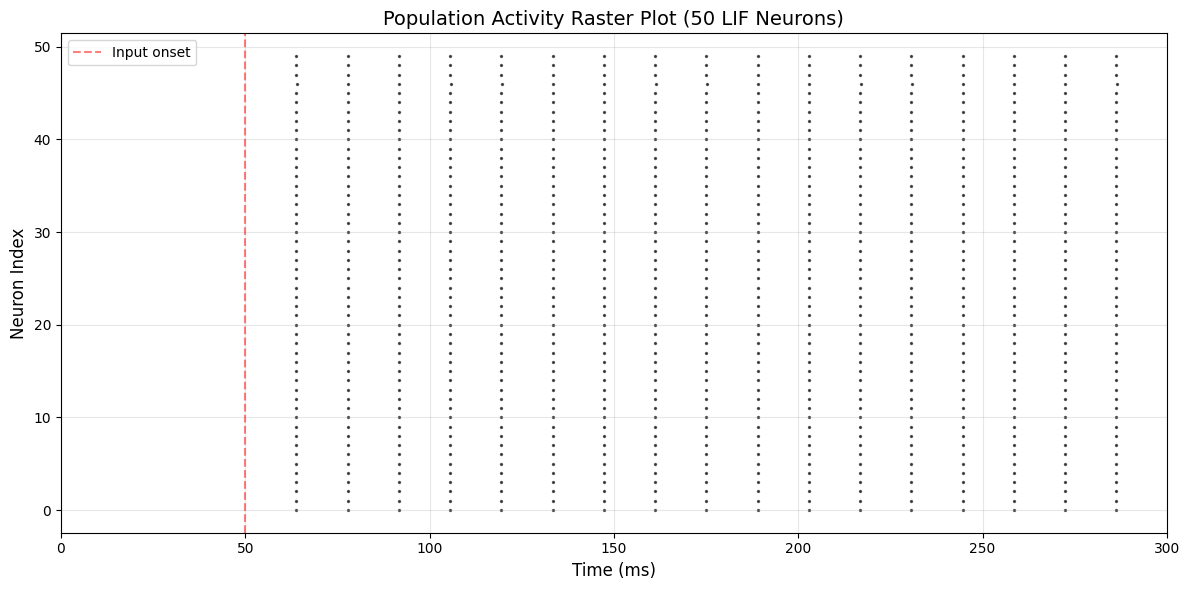

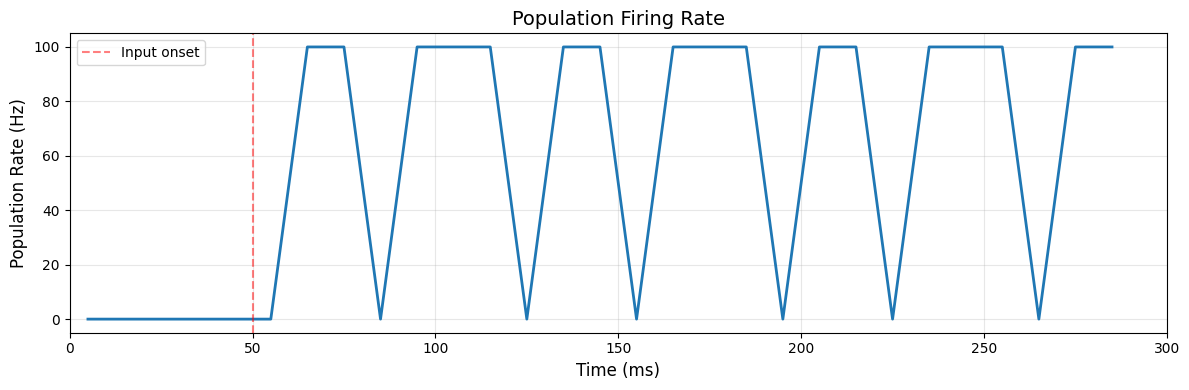

In [25]:
# Raster plot
t_indices, n_indices = u.math.where(spike_history > 0)
spike_times = times[t_indices].to_decimal(u.ms)

time_max = float(duration.to_decimal(u.ms))
xticks = np.arange(0, time_max + 1, 50)

plt.figure(figsize=(12, 6))
plt.scatter(spike_times, n_indices, s=2, c='black', alpha=0.6)
plt.axvline(x=50, color='r', linestyle='--', alpha=0.5, label='Input onset')
plt.xlabel('Time (ms)', fontsize=12)
plt.ylabel('Neuron Index', fontsize=12)
plt.title('Population Activity Raster Plot (50 LIF Neurons)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, time_max)
plt.xticks(xticks)
plt.tight_layout()
plt.show()

# Population firing rate over time
bin_size = 10 * u.ms
bins = u.math.arange(0*u.ms, duration, bin_size)
pop_rate, _ = u.math.histogram(times[t_indices], bins=bins.to_decimal(u.ms))
pop_rate = pop_rate / (pop_size * bin_size.to_decimal(u.second))  # Convert to Hz

plt.figure(figsize=(12, 4))
bin_centers = bins[:-1] + bin_size/2
plt.plot(bin_centers.to_decimal(u.ms), pop_rate, linewidth=2)
plt.axvline(x=50, color='r', linestyle='--', alpha=0.5, label='Input onset')
plt.xlabel('Time (ms)', fontsize=12)
plt.ylabel('Population Rate (Hz)', fontsize=12)
plt.title('Population Firing Rate', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, time_max)
plt.xticks(xticks)
plt.tight_layout()
plt.show()

## Part 7: Effects of Different Parameters

Let's explore how changing parameters affects neuron behavior.

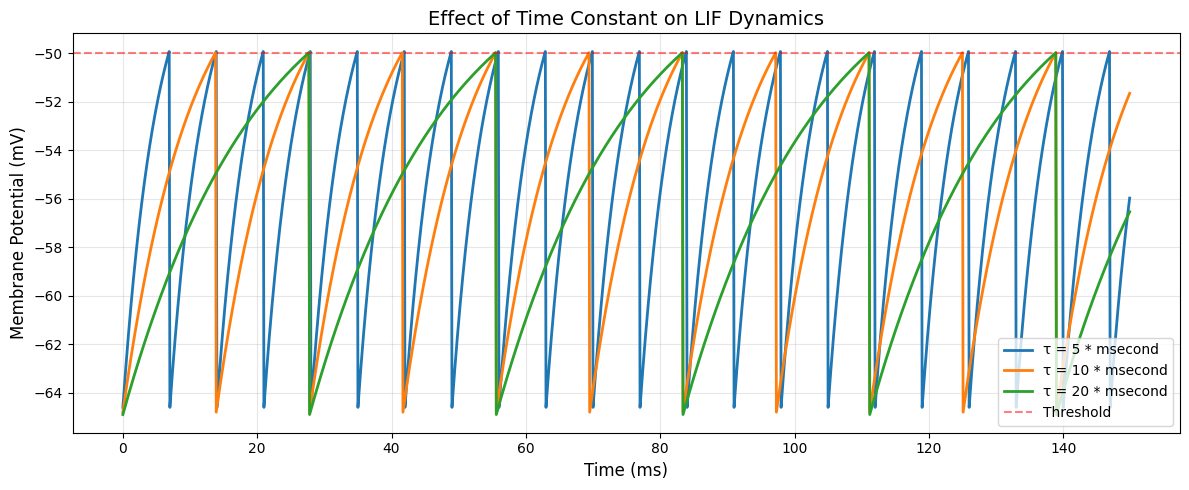

Observation: Larger τ → slower integration, lower firing rate


In [26]:
# Different time constants
taus = [5*u.ms, 10*u.ms, 20*u.ms]
neurons = [brainpy.state.LIF(1, V_rest=-65.*u.mV, V_th=-50.*u.mV,
                  V_reset=-65.*u.mV, tau=tau, spk_reset='hard') 
           for tau in taus]

# Initialize all
for n in neurons:
    brainstate.nn.init_all_states(n)

# Simulate
duration = 150. * u.ms
times = u.math.arange(0. * u.ms, duration, dt)
I_input = 20.0 * u.mA

results = {}
for tau, neuron in zip(taus, neurons):
    voltages = []
    for t in times:
        neuron(I_input)
        voltages.append(neuron.V.value)
    results[tau] = u.math.asarray(voltages)

# Plot
plt.figure(figsize=(12, 5))
for tau, voltages in results.items():
    plt.plot(times.to_decimal(u.ms), voltages.to_decimal(u.mV), 
             linewidth=2, label=f'τ = {tau}')

plt.axhline(y=-50, color='r', linestyle='--', alpha=0.5, label='Threshold')
plt.xlabel('Time (ms)', fontsize=12)
plt.ylabel('Membrane Potential (mV)', fontsize=12)
plt.title('Effect of Time Constant on LIF Dynamics', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Observation: Larger τ → slower integration, lower firing rate")

## Summary

In this tutorial, you learned:

✅ How to create and configure LIF neurons with physical units

✅ How to simulate and visualize neuron dynamics

✅ How to compute F-I curves (frequency-current relationships)

✅ The difference between hard and soft reset modes

✅ How to work with populations of neurons

✅ How parameters affect neuron behavior

## Next Steps

- **Tutorial 2**: Learn about [synapse models](02-synapse-models.ipynb)
- **Tutorial 3**: Build [connected networks](03-network-connection.ipynb)
- **Advanced**: Explore [other neuron models](01-other-neurons.ipynb) (LIFRef, ALIF)

## Exercises

Try these on your own:

1. Create a neuron with refractory period using `brainpy.state.LIFRef`
2. Implement adaptive neuron using `brainpy.state.ALIF` and observe spike-frequency adaptation
3. Generate an F-I curve for different values of τ
4. Create a population with heterogeneous time constants (use different τ for each neuron)